# Summary

- Problem statement: 
#### Binary Sentiment classification (positive, negative) of sentences
- Solution : RNN
- Data : Movie Review data (Imdb dataset)
- Result : 87% Accuracy
    + big L2 reg term (lambda : 0.1)
    + 8 neuron on LSTM
    + 8 neuron on Dense
    + Vocab size : 10000
    + word vector dimension : 10
    + train size : 40000 -> 45000
    + validation set size : 10000 -> 5000
    + test size : 10000
- Enlarging traning data and increasing regularization terms to evade overfitting was most effective in reaching best performance

# Learning

- Tried various methods to increase test case accuracy
    - regularization
    - Increasing the training set size
    - Changing the model structure (manipulating the number of laers, neurons)
    - Utilizing google's pretrained word2vec
    - Applying multiple models including CNN, RNN

- Learning 1: Most influential change 
    - Regularization : About 1% increase in accuracy(84 -> 85)
    - Upsizing the training data : About 2% increase in accuracy(85 -> 87%)
    
- Learning 2 : What did not made a meaningful impact
    - google'e pretrainied word2vec model didn't improved the model's accuracy, but rather caused time/data memory inefficiency with its' huge size
    - impressed by how CNN and RNN showed similar result (Note that CNN was not regularized) because this was a sequential data where rnn should show a better result
    
------------------------------------

- Test accuracy 를 높이기 위해서 다양한 시도를 함
    - 정규화
    - 트레이닝 데이터 수 증가
    - 모델 변화 (레이어 추가/감소, 뉴런 추가 감소)
    - google 의 pretrainined word2vec 사용
    - CNN, RNN 등 다양한 모델 활용
- Learning1 : 
    - 정규화의 효과 : 약 1% accuracy 증가 (84 -> 85% test set accuracy)
    - 트레이닝 데이터 수 증가 : 약 2% accuracy 증가 (85 -> 87% test set accuracy)
  이 가장 큰 효과가 있었음
- Learning 2 :
    - google 의 pretrained word2vec 사용은 유의미한 accuracy 변화가 없었고, 오히려 해당 데이터를 불러오는데 커널이 꺼지는 비효율을 발생시킴
    - CNN과 RNN의 효과가 거의 유사했던 것이 인상적 (단 CNN 에서는 regularize 하지 않았음)
    

# 1. Import packages, dataset etc

In [2]:
from __future__  import absolute_import, division, print_function, unicode_literals

import keras
import tensorflow as tf
import numpy as np
#Download Keras Imdb datasets : Movie review data where each words are codified into integers
imdb=keras.datasets.imdb

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
(x_train, y_train), (x_test, y_test)=imdb.load_data(num_words=10000)

/Users/hailey/opt/anaconda3/envs/python3_7/lib/python3.7/site-packages/keras/datasets/imdb.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/hailey/opt/anaconda3/envs/python3_7/lib/python3.7/site-packages/keras/datasets/imdb.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [5]:
print('test set size: {}, train set size : {}'.format(len(x_test), len(x_train)))

test set size: 25000, train set size : 25000


### Check the first X_train data

In [6]:
x_train[0][:10] #Each data is sequence of words

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [7]:
for i in range(10):
    print(len(x_train[i]))
#Each review has different length of words

218
189
141
550
147
43
123
562
233
130


In [9]:
y_train
#1:Posivie
#0: Negative

array([1, 0, 0, ..., 0, 1, 0])

In [19]:
print(sum(y_train==1),
sum(y_train==0))
#perfectly balanced data

12500 12500


# 2. Translating the codified reviews using word index

In [7]:
type(x_train)

numpy.ndarray

In [8]:
word_to_index=imdb.get_word_index()
#There is dictionary provided within the data package that can translate the codified reviews into human language

In [9]:
type(word_to_index)

dict

In [10]:
list(word_to_index.keys())[:10]
#keys of dictionary : English words

['fawn',
 'tsukino',
 'nunnery',
 'sonja',
 'vani',
 'woods',
 'spiders',
 'hanging',
 'woody',
 'trawling']

In [11]:
list(word_to_index.values())[:10]
#Values of dictionary : Codes

[34701, 52006, 52007, 16816, 63951, 1408, 16115, 2345, 2289, 52008]

In [12]:
index_to_word={index:word for word, index in word_to_index.items()}
#Create an index to word dictionary (Key and index swapped)

In [13]:
list(index_to_word.keys())[:10]

[34701, 52006, 52007, 16816, 63951, 1408, 16115, 2345, 2289, 52008]

In [14]:
min(index_to_word.keys()) #minimum key is 1

1

In [15]:
index_to_word[1] # And the corresponding word of key=1 is "the"

'the'

In [16]:
word_to_index={k: (v+3) for k,v in word_to_index.items()}
word_to_index["<PAD>"]=0
word_to_index["<BOs>"]=1
word_to_index["<UNK>"]=2
word_to_index["<UNUSED>"]=3 

In [17]:
index_to_word={index:word for word, index in word_to_index.items()}

In [18]:
index_to_word[2]

'<UNK>'

In [19]:
def get_decoded_sentence(sentence, index_to_word=index_to_word):
  return([index_to_word[i] for i in sentence])

get_decoded_sentence(x_train[0])[:10] #Decoding function : Translate codifies reviews into human words
#"This film was just brilliant casting, location, scenary, story..." : Mostly a positive feedbach

['<BOs>',
 'this',
 'film',
 'was',
 'just',
 'brilliant',
 'casting',
 'location',
 'scenery',
 'story']

# 3. Preprocessing data (checking the length of data & Padding)

In [20]:
total_data_text=list(x_train)+list(x_test)
y_train[0] 
num_tokens=[len(tokens) for tokens in total_data_text]
num_tokens=np.array(num_tokens)
import scipy
from scipy import stats
stats.describe(num_tokens)


DescribeResult(nobs=50000, minmax=(7, 2494), mean=234.75892, variance=29898.982940092403, skewness=2.1604618319867495, kurtosis=6.737652444441032)

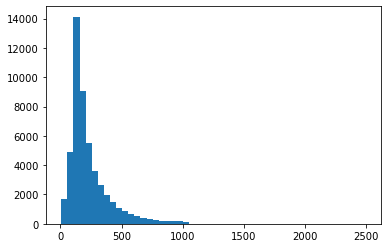

In [21]:
import matplotlib.pyplot as plt
plt.hist(num_tokens, bins=50)
plt.show()

- This graph shows the length of each movie review
- The length distribution shows skewed grapth

In [22]:
std=num_tokens.std()    
mean=num_tokens.mean()
outlier_boundary=std*2+mean
outlier_boundary=int(outlier_boundary)
print("About {}% of the sentences are within the normal boundary".format(sum(num_tokens<outlier_boundary)/len(num_tokens)*100))

About 94.502% of the sentences are within the normal boundary


In [23]:
#Preprocessing : Padding each sentences to have same length
x_train=keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=outlier_boundary)
x_train.shape
x_test=keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=outlier_boundary)

In [24]:
#Checking the lengh of each sentences : All the length has been adjusted to 580
for i in range(10):
    print(len(x_train[i]))


580
580
580
580
580
580
580
580
580
580


In [25]:
# Each sentence was padded with "0" to have length of 580
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# 3. Building model

## 1) Baseline model
- 8 neuron on LSTM
- 8 neuron on Dense
- Vocab size : 10000
- word vector dimension : 16
- Accuracy : 84 %


In [26]:
model=keras.Sequential()
vocab_size=10000
word_vector_dim=16
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [28]:
x_val=x_train[:10000]
y_val=y_train[:10000]
partial_x_train=x_train[10000:]
partial_y_train=y_train[10000:]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs=20

In [ ]:
history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=128, validation_data=(x_val, y_val))

/Users/hailey/opt/anaconda3/envs/python3_7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/20


In [ ]:
result=model.evaluate(x_test, y_test, verbose=2)

782/782 - 19s - loss: 0.5210 - accuracy: 0.8411


In [ ]:
x_train

array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

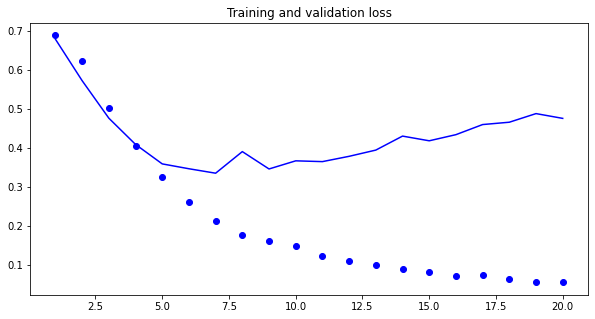

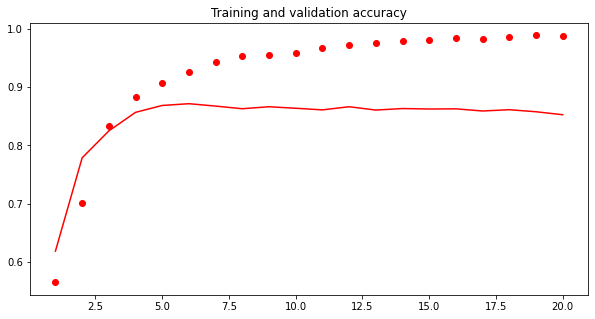

In [ ]:
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axisa, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

## 2) Decresing dimension of embedded
- 8 neuron on LSTM
- 8 neuron on Dense
- Vocab size : 10000
- **word vector dimension : 10**
- Accuracy : 84 %

In [ ]:
model=keras.Sequential()
vocab_size=10000
word_vector_dim=10
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
epochs=10
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
30/30 [==============================] - 11s 354ms/step - loss: 0.6926 - accuracy: 0.5517 - val_loss: 0.6912 - val_accuracy: 0.6022
Epoch 2/10
30/30 [==============================] - 10s 325ms/step - loss: 0.6867 - accuracy: 0.6449 - val_loss: 0.6773 - val_accuracy: 0.6380
Epoch 3/10
30/30 [==============================] - 10s 327ms/step - loss: 0.6487 - accuracy: 0.6929 - val_loss: 0.6083 - val_accuracy: 0.8116
Epoch 4/10
30/30 [==============================] - 10s 327ms/step - loss: 0.5780 - accuracy: 0.8164 - val_loss: 0.5488 - val_accuracy: 0.7840
Epoch 5/10
30/30 [==============================] - 10s 326ms/step - loss: 0.4860 - accuracy: 0.8507 - val_loss: 0.4732 - val_accuracy: 0.8413
Epoch 6/10
30/30 [==============================] - 10s 325ms/step - loss: 0.4032 - accuracy: 0.8824 - val_loss: 0.4127 - val_accuracy: 0.8504
Epoch 7/10
30/30 [==============================] - 10s 327ms/step - loss: 0.3423 - accuracy: 0.8945 - val_loss: 0.4027 - val_accuracy: 0.8388

In [ ]:
model.evaluate(x_test, y_test, verbose=2)

782/782 - 19s - loss: 0.3834 - accuracy: 0.8406


[0.38335204124450684, 0.8405600190162659]

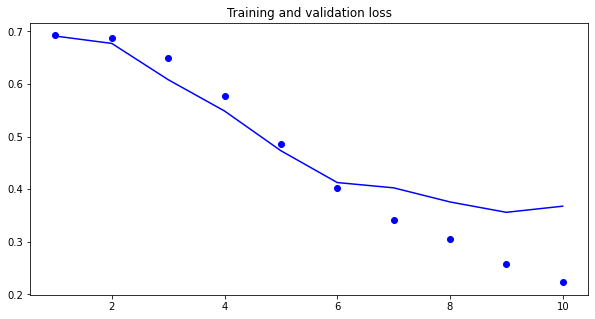

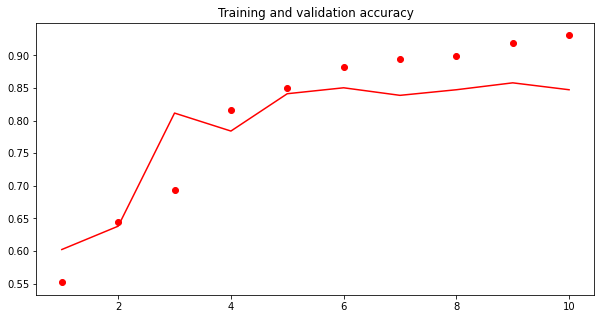

In [ ]:
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

## (3) Regularize
- with L2 reg term (lambda : 0.01)
- 8 neuron on LSTM
- 8 neuron on Dense
- Vocab size : 10000
- word vector dimension : 10
- Accuracy : 84 %

Epoch 1/5
30/30 [==============================] - 11s 367ms/step - loss: 0.7678 - accuracy: 0.5553 - val_loss: 0.7587 - val_accuracy: 0.6727
Epoch 2/5
30/30 [==============================] - 10s 338ms/step - loss: 0.7441 - accuracy: 0.7301 - val_loss: 0.7191 - val_accuracy: 0.7633
Epoch 3/5
30/30 [==============================] - 10s 337ms/step - loss: 0.6573 - accuracy: 0.7879 - val_loss: 0.6101 - val_accuracy: 0.8075
Epoch 4/5
30/30 [==============================] - 10s 338ms/step - loss: 0.5433 - accuracy: 0.8403 - val_loss: 0.5118 - val_accuracy: 0.8347
Epoch 5/5
30/30 [==============================] - 11s 364ms/step - loss: 0.4463 - accuracy: 0.8812 - val_loss: 0.4589 - val_accuracy: 0.8461
782/782 - 19s - loss: 0.4659 - accuracy: 0.8408
test result accuracy : [0.46594372391700745, 0.8408399820327759]


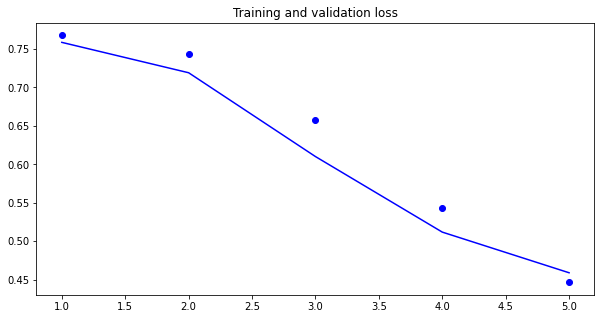

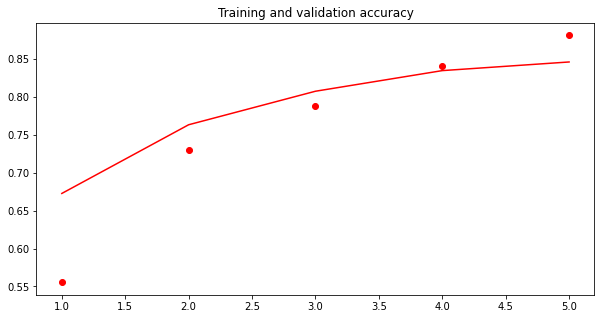

In [ ]:
from keras.regularizers import l2
l2=l2(0.01)
model=keras.Sequential()
vocab_size=10000
word_vector_dim=10
epochs=5
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

## (4) Regularize more : accuracy 1% increase
- **with L2 reg term (lambda : 0.1)**
 - Regularize 의 정도를 높이기 위해 l2 람다를 0.01로 올림
- 8 neuron on LSTM
- 8 neuron on Dense
- Vocab size : 10000
- word vector dimension : 10

- Accuracy : 85 %

Epoch 1/15
30/30 [==============================] - 11s 367ms/step - loss: 1.3929 - accuracy: 0.5453 - val_loss: 1.3359 - val_accuracy: 0.6005
Epoch 2/15
30/30 [==============================] - 10s 341ms/step - loss: 1.2815 - accuracy: 0.6761 - val_loss: 1.2188 - val_accuracy: 0.7152
Epoch 3/15
30/30 [==============================] - 10s 342ms/step - loss: 1.1069 - accuracy: 0.7679 - val_loss: 1.0385 - val_accuracy: 0.7520
Epoch 4/15
30/30 [==============================] - 10s 342ms/step - loss: 0.9387 - accuracy: 0.8204 - val_loss: 0.8927 - val_accuracy: 0.8333
Epoch 5/15
30/30 [==============================] - 10s 337ms/step - loss: 0.8155 - accuracy: 0.8689 - val_loss: 0.7960 - val_accuracy: 0.8538
Epoch 6/15
30/30 [==============================] - 10s 343ms/step - loss: 0.7143 - accuracy: 0.8963 - val_loss: 0.7234 - val_accuracy: 0.8634
Epoch 7/15
30/30 [==============================] - 10s 339ms/step - loss: 0.6308 - accuracy: 0.9136 - val_loss: 0.6768 - val_accuracy: 0.8594

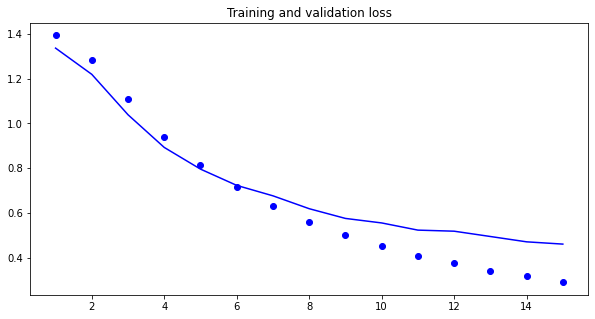

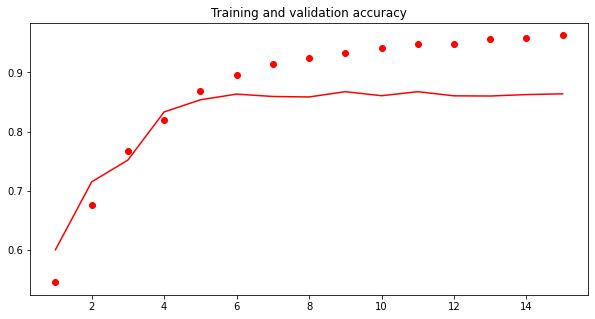

In [ ]:
from keras.regularizers import l2
l2=l2(0.1)
model=keras.Sequential()
vocab_size=10000
word_vector_dim=10
epochs=15
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

x_val=x_train[:10000]
y_val=y_train[:10000]
partial_x_train=x_train[10000:]
partial_y_train=y_train[10000:]


history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

##(5) More training set and less test set 

- big L2 reg term (lambda : 0.1)
- 8 neuron on LSTM
- 8 neuron on Dense
- Accuracy : 85 %
- Vocab size : 10000
- word vector dimension : 10
- train size : 25000-> 40000
- test size : 25000 -> 10000

In [30]:
import sklearn
from sklearn.model_selection import train_test_split

vocab_size=10000
(x_train, y_train), (x_test, y_test)=imdb.load_data(num_words=vocab_size)
X=np.append(x_train, x_test)
Y=np.append(y_train, y_test)
x_train, x_test, y_train, y_test=train_test_split(X,Y, test_size=0.2)

x_train=keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=outlier_boundary)
x_train.shape
x_test=keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=outlier_boundary)




x_val=x_train[:10000]
y_val=y_train[:10000]
partial_x_train=x_train[10000:]
partial_y_train=y_train[10000:]

In [29]:
from keras.regularizers import l2


l2=l2(0.1)
model=keras.Sequential()
vocab_size=vocab_size
word_vector_dim=10
epochs=20

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

NameError: name 'partial_x_train' is not defined

## (6) More x 2 training set and less test set -> Best CASE!! 

- big L2 reg term (lambda : 0.1)
- 8 neuron on LSTM
- 8 neuron on Dense
- Vocab size : 10000
- word vector dimension : 10
- train size : 40000 -> 45000
- validation set size : 10000 -> 5000
- test size : 10000
- **Accuracy : 87 %**

In [31]:
vocab_size=10000
import sklearn
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test)=imdb.load_data(num_words=vocab_size)
X=np.append(x_train, x_test)
Y=np.append(y_train, y_test)
x_train, x_test, y_train, y_test=train_test_split(X,Y, test_size=0.2)

x_train=keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=outlier_boundary)
x_train.shape
x_test=keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=outlier_boundary)

x_val=x_train[:5000]
y_val=y_train[:5000]
partial_x_train=x_train[5000:]
partial_y_train=y_train[5000:]

Epoch 1/25
69/69 [==============================] - 2s 30ms/step - loss: 2.5619 - accuracy: 0.6362 - val_loss: 2.1630 - val_accuracy: 0.5084
Epoch 2/25
69/69 [==============================] - 2s 25ms/step - loss: 1.8536 - accuracy: 0.5215 - val_loss: 1.6051 - val_accuracy: 0.5060
Epoch 3/25
69/69 [==============================] - 2s 25ms/step - loss: 1.4113 - accuracy: 0.5751 - val_loss: 1.2285 - val_accuracy: 0.7310
Epoch 4/25
69/69 [==============================] - 2s 25ms/step - loss: 1.0900 - accuracy: 0.7903 - val_loss: 0.9627 - val_accuracy: 0.8062
Epoch 5/25
69/69 [==============================] - 2s 25ms/step - loss: 0.8648 - accuracy: 0.8119 - val_loss: 0.7847 - val_accuracy: 0.7976
Epoch 6/25
69/69 [==============================] - 2s 27ms/step - loss: 0.7161 - accuracy: 0.8148 - val_loss: 0.8541 - val_accuracy: 0.5750
Epoch 7/25
69/69 [==============================] - 2s 26ms/step - loss: 0.6852 - accuracy: 0.7688 - val_loss: 0.6218 - val_accuracy: 0.8080
Epoch 8/25
69

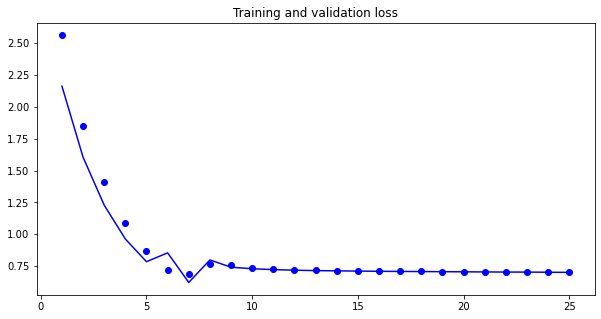

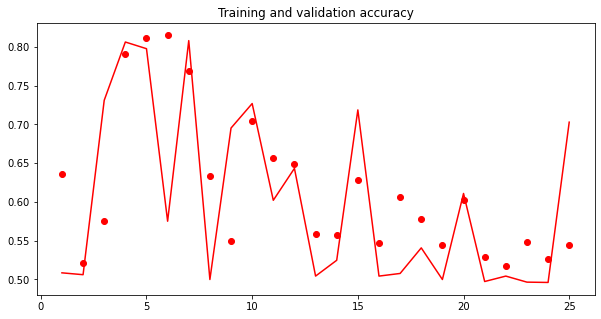

In [32]:
from keras.regularizers import l2
l2=l2(0.1)
model=keras.Sequential()
vocab_size=vocab_size
word_vector_dim=10
epochs=25

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(8, kernel_regularizer=l2))
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

## 7)  Decreasing number of neurons

Epoch 1/10
69/69 [==============================] - 18s 268ms/step - loss: 2.4660 - accuracy: 0.5436 - val_loss: 2.1525 - val_accuracy: 0.5330
Epoch 2/10
69/69 [==============================] - 16s 233ms/step - loss: 1.9149 - accuracy: 0.5801 - val_loss: 1.6807 - val_accuracy: 0.7674
Epoch 3/10
69/69 [==============================] - 16s 236ms/step - loss: 1.4988 - accuracy: 0.8093 - val_loss: 1.3335 - val_accuracy: 0.8310
Epoch 4/10
69/69 [==============================] - 18s 257ms/step - loss: 1.2038 - accuracy: 0.8480 - val_loss: 1.0967 - val_accuracy: 0.8398
Epoch 5/10
69/69 [==============================] - 16s 235ms/step - loss: 1.0218 - accuracy: 0.8113 - val_loss: 0.9419 - val_accuracy: 0.8288
Epoch 6/10
69/69 [==============================] - 16s 236ms/step - loss: 0.9473 - accuracy: 0.7118 - val_loss: 0.9529 - val_accuracy: 0.5044
Epoch 7/10
69/69 [==============================] - 16s 236ms/step - loss: 0.8971 - accuracy: 0.5138 - val_loss: 0.8572 - val_accuracy: 0.5030

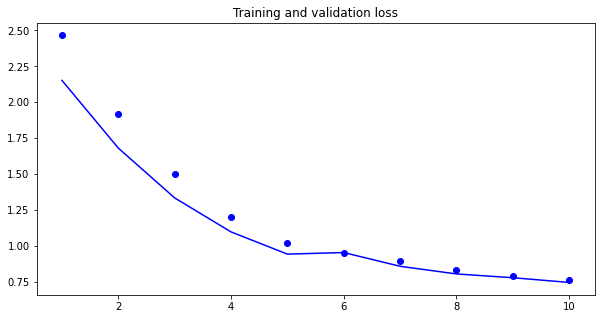

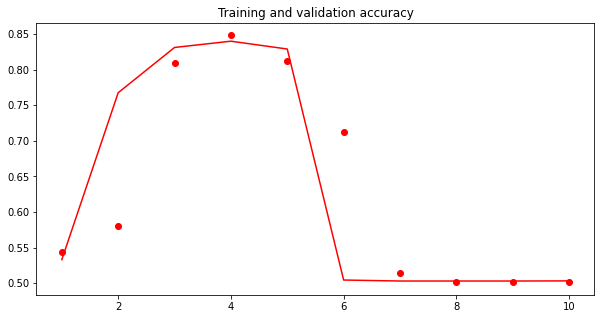

In [ ]:
from keras.regularizers import l2
l2=l2(0.1)
model=keras.Sequential()
vocab_size=vocab_size
word_vector_dim=10
epochs=10

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(4, kernel_regularizer=l2))
model.add(keras.layers.Dense(4, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(4, activation='relu', kernel_regularizer=l2))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

## (8) 모델을 길게 만들기

Epoch 1/20
69/69 [==============================] - 33s 474ms/step - loss: 2.6849 - accuracy: 0.6087 - val_loss: 2.0691 - val_accuracy: 0.7632
Epoch 2/20
69/69 [==============================] - 33s 475ms/step - loss: 1.6361 - accuracy: 0.7808 - val_loss: 1.2553 - val_accuracy: 0.8356
Epoch 3/20
69/69 [==============================] - 33s 472ms/step - loss: 1.0881 - accuracy: 0.8272 - val_loss: 0.9039 - val_accuracy: 0.8340
Epoch 4/20
69/69 [==============================] - 32s 470ms/step - loss: 0.7189 - accuracy: 0.8718 - val_loss: 0.6386 - val_accuracy: 0.8580
Epoch 5/20
69/69 [==============================] - 33s 476ms/step - loss: 0.5390 - accuracy: 0.8905 - val_loss: 0.5334 - val_accuracy: 0.8680
Epoch 6/20
69/69 [==============================] - 32s 469ms/step - loss: 0.4909 - accuracy: 0.8831 - val_loss: 0.4820 - val_accuracy: 0.8646
Epoch 7/20
69/69 [==============================] - 32s 470ms/step - loss: 0.3971 - accuracy: 0.9076 - val_loss: 0.4320 - val_accuracy: 0.8686

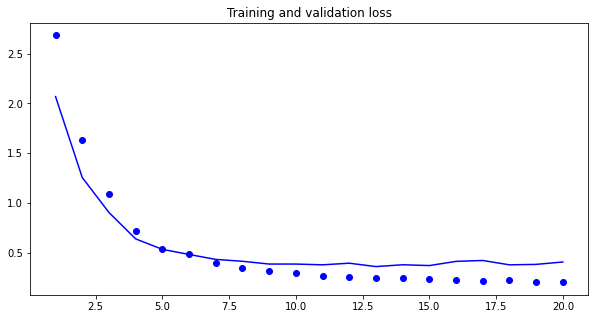

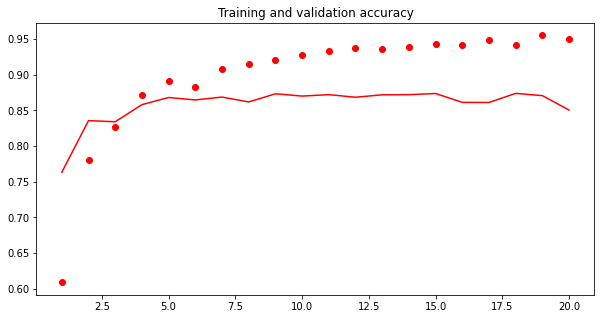

In [ ]:
from keras.regularizers import l2
l2=l2(0.1)
model=keras.Sequential()
vocab_size=vocab_size
word_vector_dim=10
epochs=20

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(16, kernel_regularizer=l2))
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

## 8) More neurons

Epoch 1/20
69/69 [==============================] - 33s 477ms/step - loss: 3.2151 - accuracy: 0.5797 - val_loss: 2.4940 - val_accuracy: 0.5006
Epoch 2/20
69/69 [==============================] - 32s 459ms/step - loss: 2.0017 - accuracy: 0.7072 - val_loss: 1.5484 - val_accuracy: 0.7978
Epoch 3/20
69/69 [==============================] - 32s 458ms/step - loss: 1.3634 - accuracy: 0.6577 - val_loss: 1.1300 - val_accuracy: 0.7800
Epoch 4/20
69/69 [==============================] - 32s 461ms/step - loss: 1.0123 - accuracy: 0.6792 - val_loss: 0.8575 - val_accuracy: 0.8284
Epoch 5/20
69/69 [==============================] - 32s 459ms/step - loss: 0.7428 - accuracy: 0.8426 - val_loss: 0.6835 - val_accuracy: 0.7966
Epoch 6/20
69/69 [==============================] - 33s 481ms/step - loss: 0.6699 - accuracy: 0.8167 - val_loss: 0.6438 - val_accuracy: 0.8200
Epoch 7/20
69/69 [==============================] - 32s 461ms/step - loss: 0.5205 - accuracy: 0.8678 - val_loss: 0.4861 - val_accuracy: 0.8596

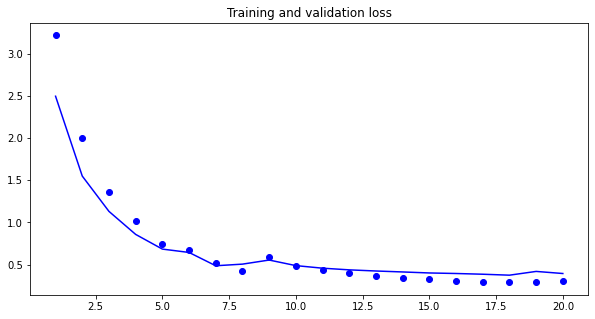

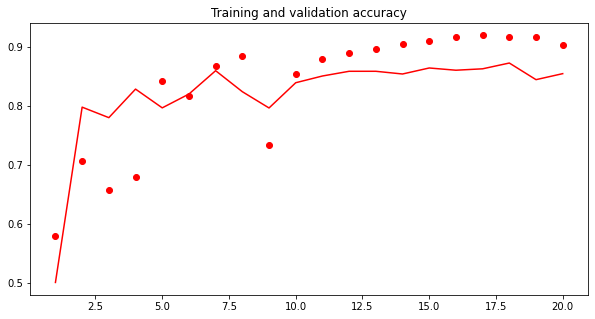

In [ ]:

from keras.regularizers import l2
l2=l2(0.1)
model=keras.Sequential()
vocab_size=vocab_size
word_vector_dim=10
epochs=20

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(16, kernel_regularizer=l2))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

## 9) More layers

- result : accuracy dropped to 50%
- learning : LSTM is prone to overfitting

Epoch 1/20
69/69 [==============================] - 33s 472ms/step - loss: 4.1094 - accuracy: 0.5164 - val_loss: 3.1922 - val_accuracy: 0.6976
Epoch 2/20
69/69 [==============================] - 32s 457ms/step - loss: 2.5892 - accuracy: 0.6728 - val_loss: 2.0944 - val_accuracy: 0.4970
Epoch 3/20
69/69 [==============================] - 32s 457ms/step - loss: 1.7532 - accuracy: 0.5047 - val_loss: 1.4623 - val_accuracy: 0.5030
Epoch 4/20
69/69 [==============================] - 32s 461ms/step - loss: 1.2747 - accuracy: 0.5010 - val_loss: 1.1129 - val_accuracy: 0.5030
Epoch 5/20
69/69 [==============================] - 33s 480ms/step - loss: 1.0088 - accuracy: 0.5010 - val_loss: 0.9193 - val_accuracy: 0.5030
Epoch 6/20
69/69 [==============================] - 32s 459ms/step - loss: 0.8621 - accuracy: 0.5010 - val_loss: 0.8130 - val_accuracy: 0.5030
Epoch 7/20
69/69 [==============================] - 32s 461ms/step - loss: 0.7820 - accuracy: 0.5010 - val_loss: 0.7554 - val_accuracy: 0.5030

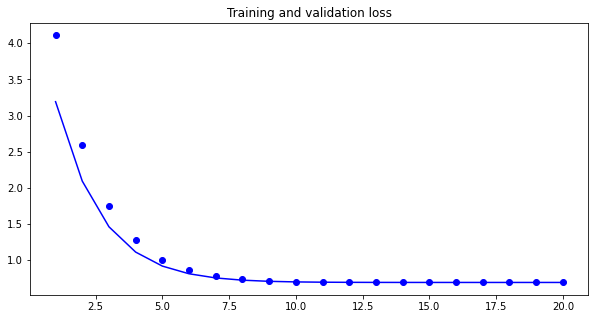

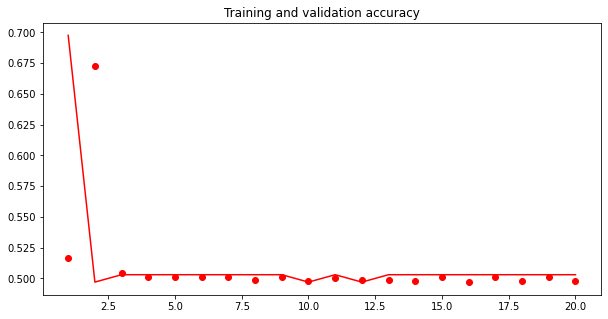

In [ ]:
from keras.regularizers import l2
l2=l2(0.1)
model=keras.Sequential()
vocab_size=vocab_size
word_vector_dim=10
epochs=20

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(16, kernel_regularizer=l2))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict=history.history
acc=history_dict['accuracy']
loss=history_dict['loss']
val_acc=history_dict['val_accuracy']
val_loss=history_dict['val_loss']
epoch_axis=range(1,epochs+1)
fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

# 4. Utilitzing Word2Vec

In [33]:
import numpy as np
import keras
from keras.datasets import imdb
import sklearn
from sklearn.model_selection import train_test_split
(x_train, y_train), (x_test, y_test)=imdb.load_data(num_words=vocab_size)
X=np.append(x_train, x_test)
Y=np.append(y_train, y_test)
x_train, x_test, y_train, y_test=train_test_split(X,Y, test_size=0.2)

x_train=keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=outlier_boundary)
x_train.shape
x_test=keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=outlier_boundary)

x_val=x_train[:5000]
y_val=y_train[:5000]
partial_x_train=x_train[5000:]
partial_y_train=y_train[5000:]


## 1) CNN model

In [34]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
print(weights)

(10000, 10)
[[-0.05594705 -0.00768938 -0.05340236 ...  0.01213985  0.02320601
   0.06246656]
 [ 0.11805663  0.01974993  0.24073973 ... -0.0075242  -0.0125765
  -0.05761702]
 [-0.04811366 -0.05273681 -0.06168048 ...  0.01437197  0.00100175
  -0.01352262]
 ...
 [ 0.08506051  0.09562019  0.0371185  ...  0.10409603 -0.09807666
  -0.11235011]
 [-0.01009757 -0.03365939 -0.03649514 ... -0.02263849  0.02528537
  -0.02877034]
 [ 0.02578883 -0.02559094 -0.04799198 ...  0.00720673  0.01062883
   0.04179902]]


In [35]:
import os
#1. 내가 만든 embedded layer 사용하기

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentimental_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

#gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [36]:
from gensim.models import KeyedVectors
word2vec_path=os.getenv('HOME')+'/aiffel/sentimental_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec=KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [37]:
word2vec

In [38]:
# 이제 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다.
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터


In [40]:
# 모델 구성
model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=outlier_boundary, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid')) 

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 114, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [42]:
# 학습의 진행
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

# 테스트셋을 통한 모델 평가
results = model_cnn.evaluate(x_test,  y_test, verbose=2)

print(results)

Epoch 1/20
69/69 [==============================] - 29s 425ms/step - loss: 0.6427 - accuracy: 0.6287 - val_loss: 0.5158 - val_accuracy: 0.7772
Epoch 2/20
69/69 [==============================] - 12s 174ms/step - loss: 0.3903 - accuracy: 0.8315 - val_loss: 0.3165 - val_accuracy: 0.8662
Epoch 3/20
69/69 [==============================] - 12s 167ms/step - loss: 0.2680 - accuracy: 0.8896 - val_loss: 0.2840 - val_accuracy: 0.8798
Epoch 4/20
69/69 [==============================] - 12s 167ms/step - loss: 0.2078 - accuracy: 0.9201 - val_loss: 0.2758 - val_accuracy: 0.8852
Epoch 5/20
69/69 [==============================] - 12s 168ms/step - loss: 0.1675 - accuracy: 0.9403 - val_loss: 0.2971 - val_accuracy: 0.8766
Epoch 6/20
69/69 [==============================] - 12s 175ms/step - loss: 0.1291 - accuracy: 0.9589 - val_loss: 0.2914 - val_accuracy: 0.8848
Epoch 7/20
69/69 [==============================] - 12s 170ms/step - loss: 0.0932 - accuracy: 0.9756 - val_loss: 0.3285 - val_accuracy: 0.8726

## 2) RNN best case model

### (1) Regularize term : 0.01 _ Accurcay : 87%

Epoch 1/25
69/69 [==============================] - 12s 174ms/step - loss: 1.0295 - accuracy: 0.6325 - val_loss: 0.7804 - val_accuracy: 0.7290
Epoch 2/25
69/69 [==============================] - 11s 166ms/step - loss: 0.5966 - accuracy: 0.8162 - val_loss: 0.5155 - val_accuracy: 0.8418
Epoch 3/25
69/69 [==============================] - 11s 163ms/step - loss: 0.4424 - accuracy: 0.8745 - val_loss: 0.4425 - val_accuracy: 0.8652
Epoch 4/25
69/69 [==============================] - 11s 163ms/step - loss: 0.3714 - accuracy: 0.9015 - val_loss: 0.4151 - val_accuracy: 0.8736
Epoch 5/25
69/69 [==============================] - 11s 163ms/step - loss: 0.3240 - accuracy: 0.9174 - val_loss: 0.3908 - val_accuracy: 0.8808
Epoch 6/25
69/69 [==============================] - 12s 168ms/step - loss: 0.2903 - accuracy: 0.9285 - val_loss: 0.3960 - val_accuracy: 0.8708
Epoch 7/25
69/69 [==============================] - 11s 164ms/step - loss: 0.2667 - accuracy: 0.9356 - val_loss: 0.3753 - val_accuracy: 0.8798

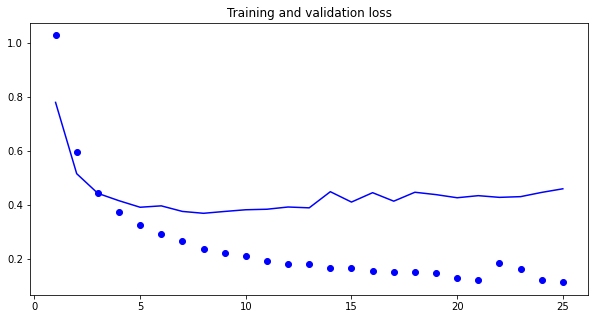

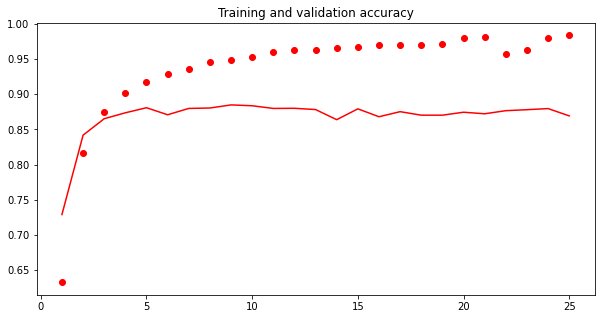

In [45]:
from keras.regularizers import l2
l2=l2(0.01)
model_rnn=keras.Sequential()
vocab_size=vocab_size
word_vector_dim=300
epochs=25

model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),
                                 trainable=True,
                                 input_shape=(None, )))
model_rnn.add(keras.layers.LSTM(8, kernel_regularizer=l2))
model_rnn.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_rnn=model_rnn.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict_rnn=history_rnn.history
acc=history_dict_rnn['accuracy']
loss=history_dict_rnn['loss']
val_acc=history_dict_rnn['val_accuracy']
val_loss=history_dict_rnn['val_loss']
epoch_axis=range(1,epochs+1)

fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()

### (2) Regularize term : lambda 0.1 _ Accuracy : 87%

Epoch 1/25
69/69 [==============================] - 12s 176ms/step - loss: 4.1456 - accuracy: 0.6001 - val_loss: 2.1677 - val_accuracy: 0.6656
Epoch 2/25
69/69 [==============================] - 12s 172ms/step - loss: 1.4939 - accuracy: 0.7515 - val_loss: 1.0861 - val_accuracy: 0.8350
Epoch 3/25
69/69 [==============================] - 11s 166ms/step - loss: 0.9293 - accuracy: 0.8331 - val_loss: 0.8055 - val_accuracy: 0.8580
Epoch 4/25
69/69 [==============================] - 11s 166ms/step - loss: 0.7330 - accuracy: 0.8625 - val_loss: 0.6944 - val_accuracy: 0.8404
Epoch 5/25
69/69 [==============================] - 12s 167ms/step - loss: 0.6167 - accuracy: 0.8785 - val_loss: 0.5758 - val_accuracy: 0.8776
Epoch 6/25
69/69 [==============================] - 11s 166ms/step - loss: 0.5295 - accuracy: 0.8913 - val_loss: 0.5167 - val_accuracy: 0.8744
Epoch 7/25
69/69 [==============================] - 11s 166ms/step - loss: 0.4727 - accuracy: 0.8959 - val_loss: 0.4691 - val_accuracy: 0.8790

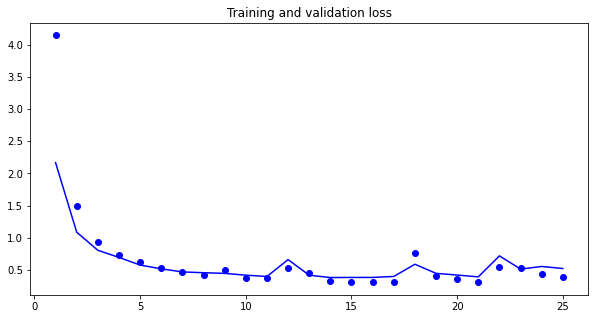

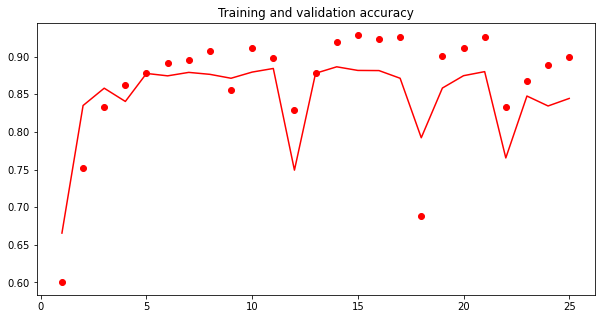

In [46]:
from keras.regularizers import l2
l2=l2(0.1)
model_rnn=keras.Sequential()
vocab_size=vocab_size
word_vector_dim=300
epochs=25

model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),
                                 trainable=True,
                                 input_shape=(None, )))
model_rnn.add(keras.layers.LSTM(8, kernel_regularizer=l2))
model_rnn.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=l2))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_rnn=model_rnn.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)
print("test result accuracy : {}".format(model.evaluate(x_test, y_test, verbose=2)[1]))
history_dict_rnn=history_rnn.history
acc=history_dict_rnn['accuracy']
loss=history_dict_rnn['loss']
val_acc=history_dict_rnn['val_accuracy']
val_loss=history_dict_rnn['val_loss']
epoch_axis=range(1,epochs+1)

fig=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, loss, 'bo', label='Training loss')
plt.plot(epoch_axis, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.show()

fig2=plt.figure(figsize=(10,5))
plt.plot(epoch_axis, acc, 'ro', label='Training accuracy')
plt.plot(epoch_axis, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.show()